In [1]:
import folium

from openrouteservice import client
import openrouteservice

from pprint import pprint

import matplotlib.pyplot as plt
from matplotlib import pylab

In [2]:
def style_function(color):
    return lambda feature: dict(color=color)

Let's have a look for the reachability of each location for different kind of profiles.
- foot-walking
- driving-car


- 5 minutes
- 15 minutes

In [6]:
api_key = '58d904a497c67e00015b45fc2a6b6872037d44119582ef40cdf264c4' # Provide your personal API key
clnt = client.Client(key=api_key) # Create client with api key
map_berlin = folium.Map(tiles='Stamen Toner', location=([52.515803, 13.390617]), zoom_start=11) # Set up folium map

location_options = [13.353882, 52.570716], [13.311653, 52.518937], [13.327103, 52.489888], [13.378258, 52.50452], [13.446579, 52.489888], [13.440056, 52.536482], [13.382893, 52.540188]
foot_iso = []
foot_pop = []
car_iso = []
car_pop = []
for loc in location_options:
    
    # foot profile
    iso_params = {'locations': loc,
                  'profile': 'foot-walking',
                  'range_type': 'time',
                  'intervals': [300, 900], # 5 and 15 minutes
                  'attributes': {'total_pop', 'area', 'reachfactor'}
                 }
    iso_foot_request = clnt.isochrones(**iso_params)
    foot_iso.append(iso_foot_request)
    folium.Marker(list(reversed(loc)),popup='Store Option {}'.format(location_options.index(loc)+1)).add_to(map_berlin)
    
    for feature in iso_foot_request['features']:
        coords = [(y,x) for x,y in feature['geometry']['coordinates'][0]]
        folium.features.PolygonMarker(coords,
                                         color='#ffd699',
                                         fill_color='#ffd699',
                                        fill_opacity=0.2,
                                         weight=3).add_to(map_berlin)
        
        foot_pop += [feature['properties']['total_pop']]
        
    
    # car profile
    del iso_params['profile']
    iso_params['profile'] = 'driving-car' # Change profile from foot-walking to driving-car
    
    # It is also possible to use the segments parameter instead of intervals
    del iso_params['intervals']
    iso_params['segments'] = 300 # 5 minutes
    
    iso_car_request = clnt.isochrones(**iso_params) # Request for car profile with an time range of 300 seconds or 5 minutes
    folium.GeoJson(iso_car_request).add_to(map_berlin)
    car_iso.append(iso_car_request)
    
    for feature in iso_car_request['features']:
        car_pop += [feature['properties']['total_pop']]
    
map_berlin

<BarContainer object of 7 artists>

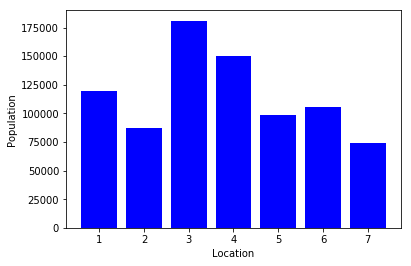

In [18]:
# Where can I reach the most people? / Highest population density
pop_values = []
for iso in car_iso:
    pop_values += [iso['features'][0]['properties']['total_pop']]
    
# population plot    
y = pop_values
N = (len(y)+1)
x = range(1,N)
pylab.xlabel('Location')
pylab.ylabel('Population')
plt.bar(x, y, color="blue")

In [7]:
loc_choise = [car_iso[2], car_iso[3]] # 

# Highest population density in 15 minute foot and 5 minute car catchments 
for iso in foot_iso:
    for loc in iso['features']: 
        if loc['properties']['total_pop'] == max(foot_pop):
            print('There is a total population of {} and a reachfactor of {} in the chosen area.'.format(iso['features'][0]['properties']['total_pop'], iso['features'][0]['properties']['reachfactor']))
            folium.GeoJson(iso, style_function=style_function('red')).add_to(map_berlin)
        
for iso in car_iso:
    if iso['features'][0]['properties']['total_pop'] == max(car_pop):
        print('There is a total population of {} and a reachfactor of {} in the chosen area.'.format(iso['features'][0]['properties']['total_pop'], iso['features'][0]['properties']['reachfactor']))
        folium.GeoJson(iso, style_function=style_function('red')).add_to(map_berlin)
        
map_berlin

There is a total population of 5140 and a reachfactor of 0.9059 in the chosen area.
There is a total population of 180935 and a reachfactor of 0.173 in the chosen area.


In [21]:
# Cleaning up map
cleaned_map = folium.Map(tiles='Stamen Toner', location=([52.489888, 13.327103]), zoom_start=11) # Set up folium map
for loc in loc_choise:
    folium.GeoJson(loc).add_to(cleaned_map)
    # The two shop options with the highest population density
    folium.Marker(list(reversed(loc['features'][0]['properties']['center'])), popup='Shop Option {}'.format(loc_choise.index(loc)+1)).add_to(cleaned_map)

    
# Supplier
supplier_list = [[13.178101, 52.551724], [13.445892, 52.422523], [13.567429, 52.566752]]

for sup in supplier_list:
    folium.Marker(list(reversed(sup)), popup='Supplier').add_to(cleaned_map)
    
cleaned_map

In [13]:
# Delivery time for suppliers
for loc in loc_choise:
    supplier_list.append(loc['features'][0]['properties']['center'])
    
matrix_request = []
matrix_params = {'locations': supplier_list,
                'profile': 'driving-hgv',
                'resolve_locations':'true',
                'sources': [4,5] # shop locations
                }
matrix_request.append(clnt.distance_matrix(**matrix_params))
    
counter = 0
print('Delivery time for the suppliers: \n ')
for dura in matrix_request[0]['durations']:
    counter += 1
    print('  To the {} location: {:.2f} minutes'.format(counter, sum(dura[0:3])/60))

Delivery time for the suppliers: 
 
  To the 1 location: 62.28 minutes
  To the 2 location: 67.02 minutes
